## **Solving an Optimization Problem in an Active RIS-Assisted ISAC System Using DRL Algorithms (DDPG and SAC).**

This project focuses on solving an optimization problem in an active Reconfigurable Intelligent Surface (RIS)-assisted Integrated Sensing and Communication (ISAC) system using Deep Reinforcement Learning (DRL) algorithms. The goal is to maximize the dual-function radar sensing base station (DFRC BS) by jointly optimizing the beamforming matrix
𝑊
W of the base station and the reflection phase shift matrix of the active RIS, all while ensuring the Signal-to-Interference-plus-Noise Ratio (SINR) of the communication user is maintained. The project employs DRL algorithms, specifically Deep Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC), to achieve the optimization. It involves creating a custom environment in OpenAI Gym, integrating it with Stable Baselines3 for training the DRL models, and comparing the performance and convergence of ordinary DDPG, double DDPG, and SAC algorithms through simulation and graphical analysis. The outcome of this project aims to enhance the efficiency and performance of ISAC systems in modern wireless communication networks.








Installing the necessary libraries

In [2]:
!pip install stable_baselines3 #Install if necessary or lacking

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [3]:
!pip install gymnasium #Install if necessary or lacking

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12       |
|    ep_rew_mean     | -14.7    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 256      |
|    time_elapsed    | 0        |
|    total_timesteps | 48       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.75     |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 264      |
|    time_elapsed    | 0        |
|    total_timesteps | 78       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12       |
|    ep_rew_mean     | -12.2    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 62       |
|    time_elapsed    | 2        |
|    total_timesteps | 144     

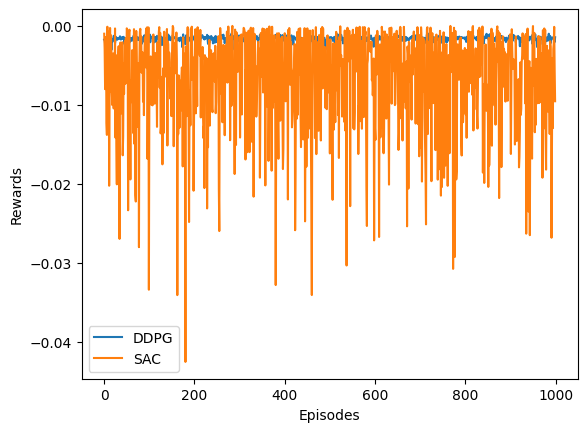

In [5]:
#Import all the neccessary libraries
import gymnasium as gym
import numpy as np
import torch
from stable_baselines3 import DDPG, SAC
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

# Define the custom environment for the ISAC system optimization problem
class ISACEnv(gym.Env):
    def __init__(self):
        super(ISACEnv, self).__init__()
        # This section Define action and observation space
        # The action space could include beamforming and phase shift parameters
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.float32)
        # The observation space could include SINR values and other relevant system states
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        # Reset the state of the environment to an initial state
        super().reset(seed=seed)
        self.state = np.random.rand(4)
        info = {}  # Additional reset info, can be empty
        return self.state, info

    def step(self, action):
        # Implement the step logic to update the environment state based on the action
        # Here we use a dummy reward function for illustration purposes
        reward = -np.sum((action - 0.5)**2)
        self.state = np.random.rand(4)
        terminated = np.random.rand() > 0.95  # Randomly determine if the episode is terminated
        truncated = False  # For simplicity, assume episodes are never truncated
        info = {}
        return self.state, reward, terminated, truncated, info

    def render(self, mode='human', close=False):
        # Implement the render logic
        pass

# Create and wrap the environment
env = DummyVecEnv([lambda: Monitor(ISACEnv())])

# Create action noise for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Train DDPG model
ddpg_model = DDPG('MlpPolicy', env, action_noise=action_noise, verbose=1, device='cpu')
ddpg_model.learn(total_timesteps=10000)

# Train SAC model
sac_model = SAC('MlpPolicy', env, verbose=1, device='cpu')
sac_model.learn(total_timesteps=10000)

# Compare the performance of the models
ddpg_rewards = []
sac_rewards = []

# Unwrap the environment to access the original env for evaluation
unwrapped_env = env.envs[0]

obs, _ = unwrapped_env.reset()
for _ in range(1000):
    action, _states = ddpg_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = unwrapped_env.step(action)
    ddpg_rewards.append(reward)
    if terminated:
        obs, _ = unwrapped_env.reset()

obs, _ = unwrapped_env.reset()
for _ in range(1000):
    action, _states = sac_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = unwrapped_env.step(action)
    sac_rewards.append(reward)
    if terminated:
        obs, _ = unwrapped_env.reset()

# Plot the results
import matplotlib.pyplot as plt

plt.plot(ddpg_rewards, label='DDPG')
plt.plot(sac_rewards, label='SAC')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()
